In [1]:
import torch
from torch import optim, nn, utils, Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
# Define CNN encoder
class Encoder(nn.Module):
    def __init__(self, data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim):
        super(Encoder, self).__init__()
        # Layers
        self.conv_dataA = nn.Conv2d(data_channels, channels_A, kernel_size=5, stride=2)
        self.conv_AB    = nn.Conv2d(channels_A, channels_B, kernel_size=3, stride=1)
        self.conv_BC    = nn.Conv2d(channels_B, channels_C, kernel_size=5, stride = 1)
        self.conv_CD    = nn.Conv2d(channels_C, channels_D, kernel_size=3, stride = 1)
        self.fc_Dmean   = nn.Linear(channels_D * 16, latent_dim)
        self.fc_Dlog_var= nn.Linear(channels_D * 16, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv_dataA(x))
        x = F.relu(self.conv_AB(x))
        x = F.relu(self.conv_BC(x))
        x = F.relu(self.conv_CD(x))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_Dmean(x)
        log_var = self.fc_Dlog_var(x)
        return mu, log_var

In [3]:
# Define CNN decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels):
        super(Decoder, self).__init__()
        self.channels_D = channels_D
        # Layers
        self.fc_LatentD = nn.Linear(latent_dim, channels_D * 16)
        self.conv_tDC   = nn.ConvTranspose2d(channels_D, channels_C, kernel_size=3, stride=1)
        self.conv_tCB   = nn.ConvTranspose2d(channels_C, channels_B, kernel_size=5, stride=1)
        self.conv_tBA   = nn.ConvTranspose2d(channels_B, channels_A, kernel_size=3, stride=1)
        self.conv_tAdata= nn.ConvTranspose2d(channels_A, data_channels, kernel_size=5, stride=2, output_padding=1)

    def forward(self, z):
        z = F.relu(self.fc_LatentD(z))
        z = z.view(-1, self.channels_D, 4, 4)
        z = F.relu(self.conv_tDC(z))
        z = F.relu(self.conv_tCB(z))
        z = F.relu(self.conv_tBA(z))
        recon = torch.sigmoid(self.conv_tAdata(z))
        return recon

In [4]:
# Define VAE
class VAE(nn.Module):
    def __init__(self, latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(data_channels, channels_A, channels_B, channels_C, channels_D, latent_dim)
        self.decoder = Decoder(latent_dim, channels_D, channels_C, channels_B, channels_A, data_channels)

    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)

    def forward(self, x, do_reparam = True):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var) if do_reparam else mu
        return self.decoder(z), mu, log_var

In [5]:
# Define Evaluator
class Evaluator(nn.Module):    # Non-biased Feature Extractor
    def __init__(self, data_dim, hidden_dim1, hidden_dim2, value_dim):
        super(Evaluator, self).__init__()
        # Layers
        self.fc_x0h = nn.Linear(data_dim, hidden_dim1)
        self.fc_x1h = nn.Linear(data_dim, hidden_dim1)
        self.fc_h0 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc_h1 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc_state = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_eval = nn.Linear(hidden_dim2*2, value_dim)

    def forward(self, x0, x1):
        x0 = torch.flatten(x0, start_dim = 1)
        x1 = torch.flatten(x1, start_dim = 1)
        h0 = F.relu(self.fc_x0h(x0))
        h1 = F.relu(self.fc_x1h(x1))
        h00 = self.fc_h0(h0)
        h10 = self.fc_h0(h1)
        h01 = self.fc_h1(h0)
        h11 = self.fc_h1(h1)
        hA = F.relu(h00 + h11)
        hB = F.relu(h01 + h10)
        sA = F.relu(self.fc_state(hA))
        sB = F.relu(self.fc_state(hB))
        values = F.relu(self.fc_eval(torch.concat((sA,sB), dim=1)))
        return values

In [6]:
# Randomness control
torch.manual_seed(2022313045)

# Metadata
dataset_folder = '../../../Datasets'
data_is_rgb = False
data_channels = 3 if data_is_rgb else 1
data_x = 28
data_y = 28
latent_dim = 40
channels_D = 40*data_channels
channels_C = 27*data_channels
channels_B = 18*data_channels
channels_A = 12*data_channels
data_dim = data_x*data_y*data_channels
hidden_dim1 = 400
hidden_dim2 = 200
value_dim = 100

# Set computing device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

    # Datasets
data_test = MNIST(dataset_folder, train=False, transform=transform)

# Neural Networks
model = VAE(latent_dim, channels_A, channels_B, channels_C, channels_D, data_channels).to(device)
evaluator = Evaluator(data_dim, hidden_dim1, hidden_dim2, value_dim).to(device)

In [7]:
checkpoint = torch.load('EVAE_mnist_evaluator5.pt', map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
evaluator.load_state_dict(checkpoint['evaluator_state_dict'])

model.eval()
evaluator.eval()

Evaluator(
  (fc_x0h): Linear(in_features=784, out_features=400, bias=True)
  (fc_x1h): Linear(in_features=784, out_features=400, bias=True)
  (fc_h0): Linear(in_features=400, out_features=400, bias=True)
  (fc_h1): Linear(in_features=400, out_features=400, bias=True)
  (fc_state): Linear(in_features=400, out_features=200, bias=True)
  (fc_eval): Linear(in_features=400, out_features=100, bias=True)
)

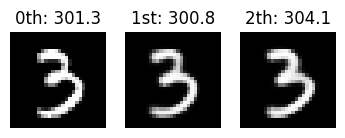

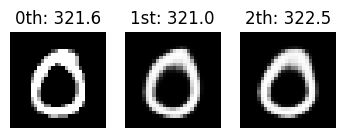

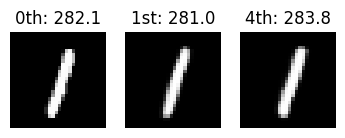

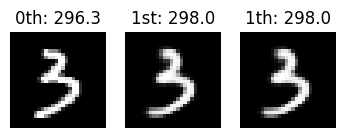

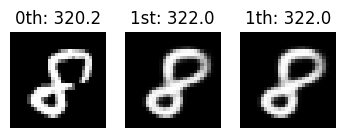

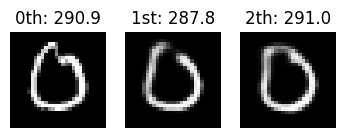

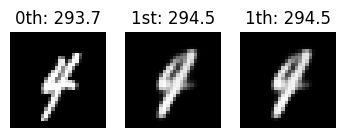

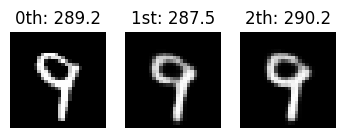

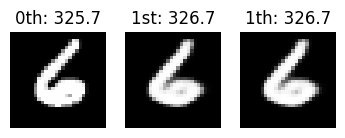

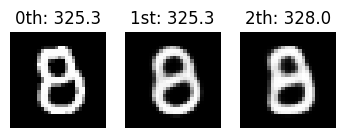

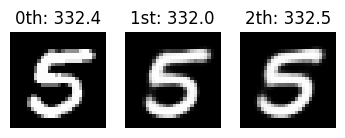

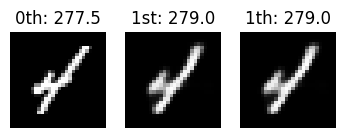

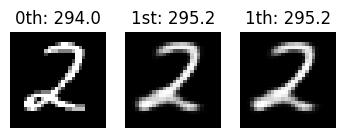

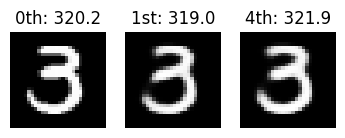

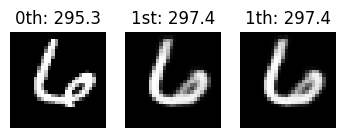

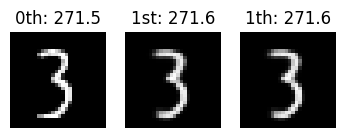

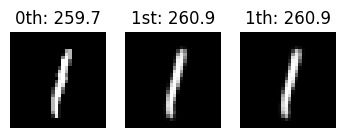

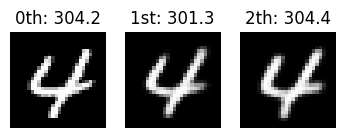

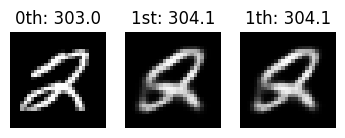

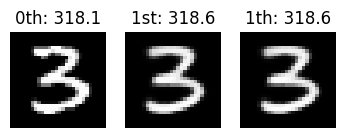

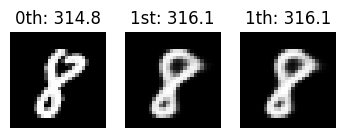

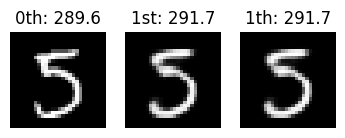

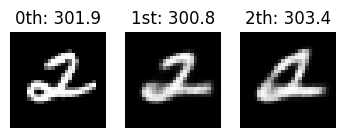

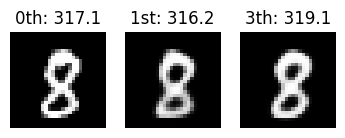

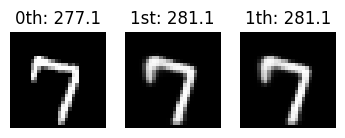

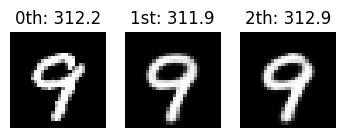

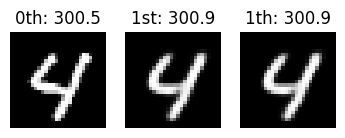

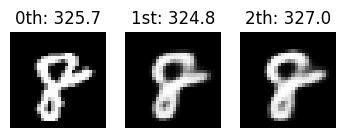

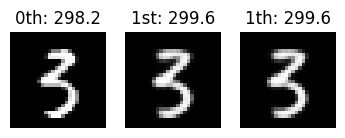

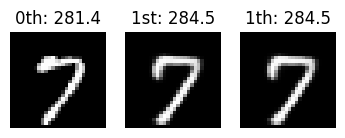

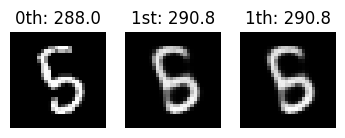

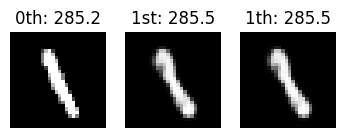

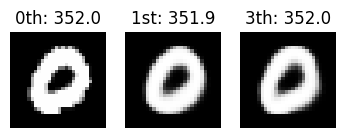

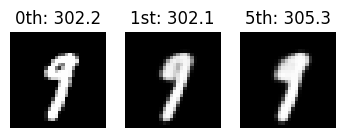

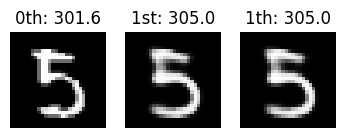

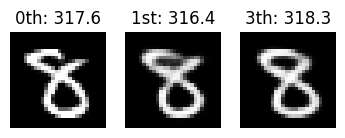

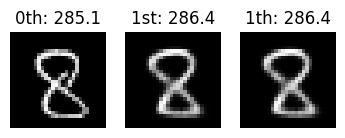

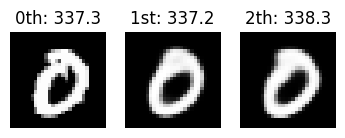

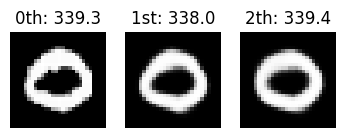

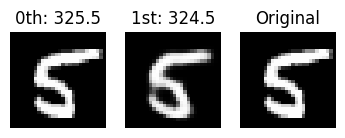

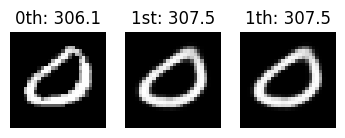

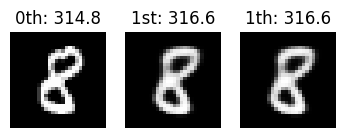

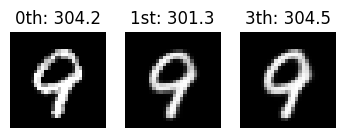

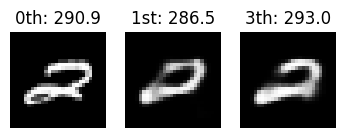

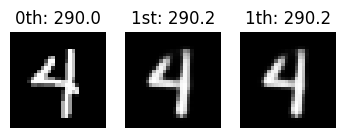

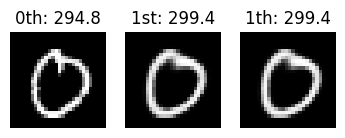

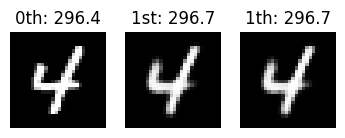

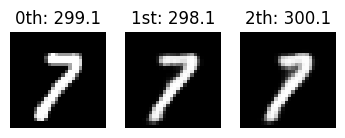

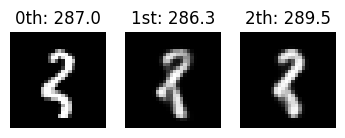

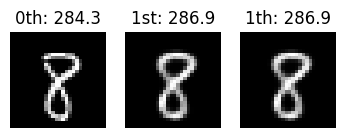

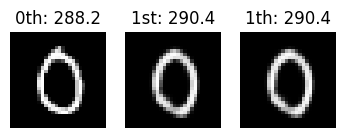

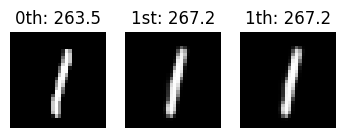

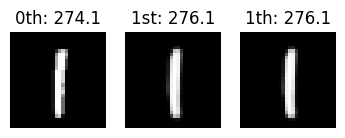

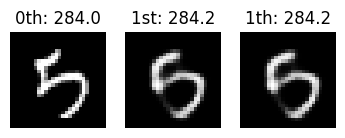

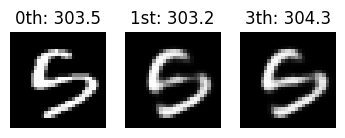

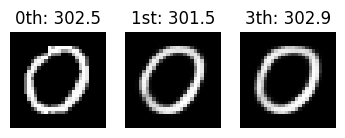

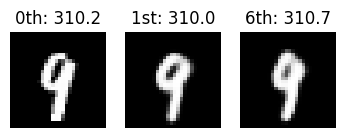

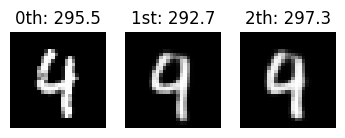

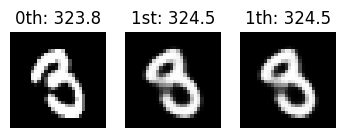

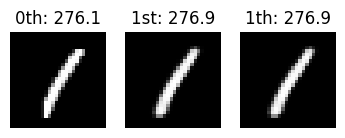

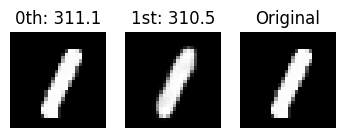

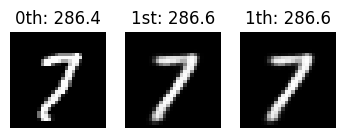

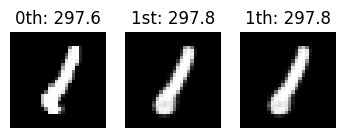

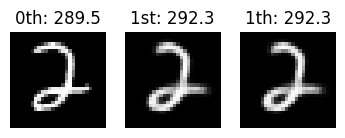

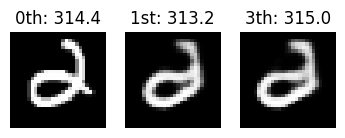

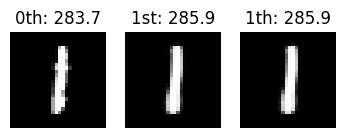

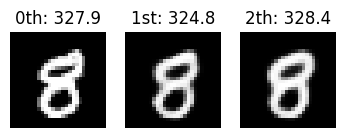

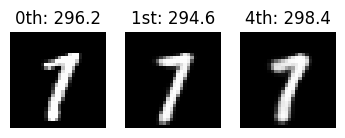

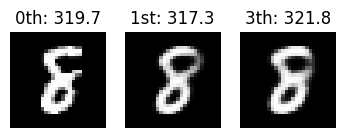

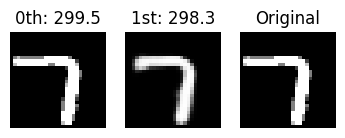

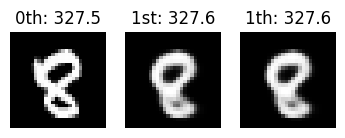

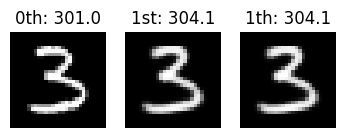

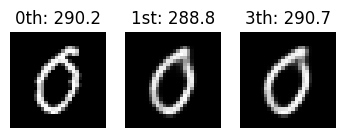

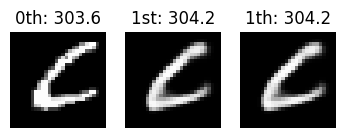

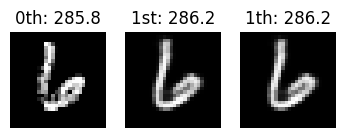

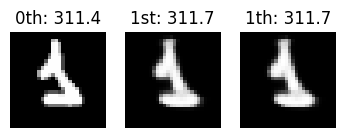

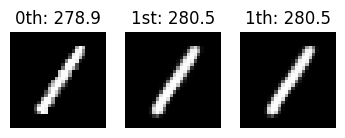

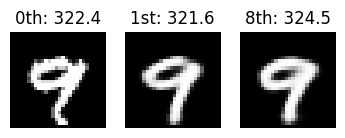

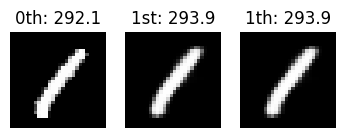

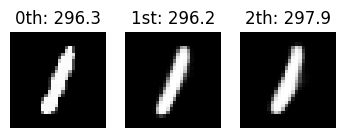

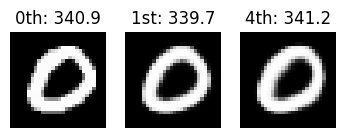

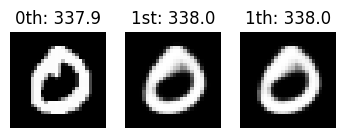

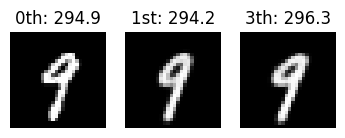

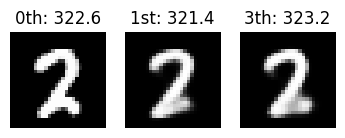

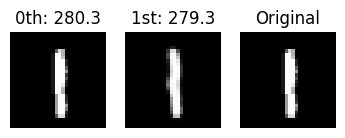

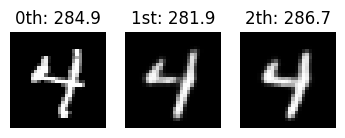

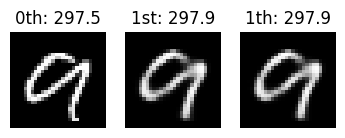

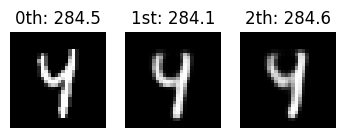

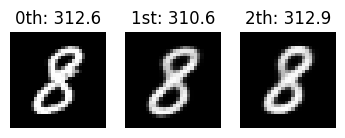

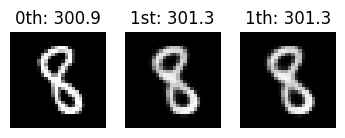

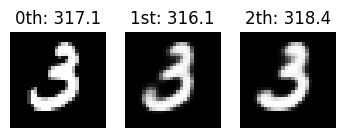

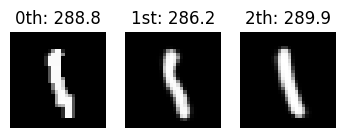

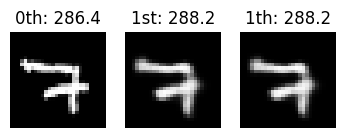

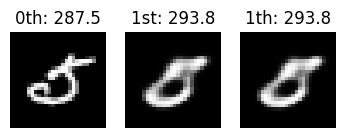

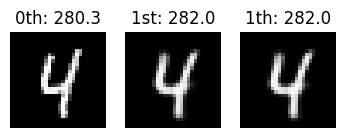

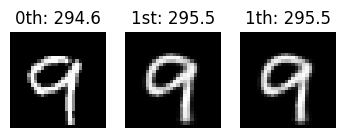

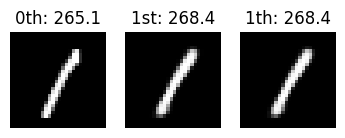

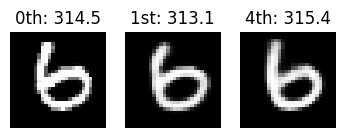

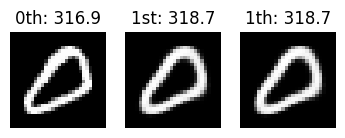

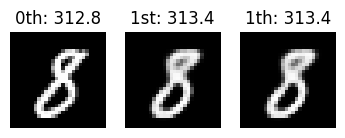

In [8]:
# Testing
data_loader = DataLoader(data_test, batch_size = 100, shuffle = True)
sampling = 10

for data, data_label in data_loader:
    fig, axes = plt.subplots(1, 3, figsize=(6*0.7, 2))
    image = data[0].to(device)
    image = image.reshape(1,1,28,28)
    values = evaluator(image.reshape(image.size(0),-1),image.reshape(image.size(0),-1))[0]
    image_origin = image[0][0].cpu()
    value_origin = torch.log(values+1).sum().item()
    axes[0].imshow(image_origin, cmap='gray')
    axes[0].set_title(f'0th: {value_origin:.1f}')
    axes[0].axis('off')  # Turn off axis numbers

    count = 0
    for i in range(1, sampling):
        recon_x, mean, log_var = model(image)
        values = evaluator(image.reshape(image.size(0),-1),recon_x.reshape(1,-1))[0]
        value_image = torch.log(values+1).sum().item()

        if i == 1:
            value = value_image
            axes[1].imshow(recon_x[0][0].detach().cpu(), cmap='gray')
            axes[1].set_title(f'1st: {value_image:.1f}')
            axes[1].axis('off')  # Turn off axis numbers

        if value_image >= value and value_image > value_origin:
            count += 1
            value = value_image
            axes[2].imshow(recon_x[0][0].detach().cpu(), cmap='gray')
            axes[2].set_title(f'{i}th: {value_image:.1f}')
            axes[2].axis('off')  # Turn off axis numbers
            if count == 1:
                break
    if count == 0:
        axes[2].imshow(image_origin, cmap='gray')
        axes[2].set_title(f'Original')
        axes[2].axis('off')  # Turn off axis numbers
    plt.show()
    plt.close()